# Identify Customer Segments

In this project, we apply unsupervised learning techniques to identify segments of the population that form the core customer base for an mail-order company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Here we import the preprocessing library which is necessary to preprocess categorical features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import library to handle regular expressions
import re

# magic word for producing visualizations in notebook
%matplotlib inline

'''Import note: The classroom currently uses sklearn version 0.19. If you need to use an imputer, it is available in 
sklearn.preprocessing.Imputer, instead of sklearn.impute as in newer versions of sklearn.'''

'Import note: The classroom currently uses sklearn version 0.19. If you need to use an imputer, it is available in \nsklearn.preprocessing.Imputer, instead of sklearn.impute as in newer versions of sklearn.'

### Step 0: Loading the Data

There are four files associated with the task of the present notebook:

- `gen_pop.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `customers.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `info.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Our hope here is that, once we have clustered both general population and customers with the same framework, certain clusters are over-represented in the customers data,as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
gen_pop = pd.read_csv('gen_pop.csv')
# Load in the feature summary file.
feat_info = pd.read_csv('info.csv')

In [3]:
# Removing the first redundant columns
gen_pop.drop(columns=['Unnamed: 0'],inplace=True)
feat_info.drop(columns=['Unnamed: 0'],inplace=True)

In [108]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows
gen_pop

In [5]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,ager_type,person,categorical,"[-1,0]"
1,age_name,person,ordinal,"[-1,0,9]"
2,gender,person,categorical,"[-1,0]"
3,customer_typ,person,categorical,[0]
4,fin_min,person,ordinal,[-1]
...,...,...,...,...
80,houses_num_plz8,macrocell_plz8,ordinal,[-1]
81,build_num_plz8,macrocell_plz8,ordinal,[-1]
82,comm_unemp,community,ordinal,"[-1,9]"
83,comm_size,community,ordinal,"[-1,0]"


## Step 1: Preprocessing

### Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help you make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data. 

#### Convert Missing Value Codes to NaNs

The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We also want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

# We should first identify all the possible encodings which mean 'missing or unknown data' 
# according to the dictionary,then parse them
miss_unn=feat_info.missing_or_unknown.unique()
print(miss_unn)

['[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]']


In [7]:
# Here we loop over the features and the various possible symbols identifying missing values;
# if we find that the string expression in the 'missing_or_unknown' column 
# in the feature summary table contains one or more of the strings '0','1','9','X','XX', 
# we replace the corresponding entries with NaN; in the end, I do it for the string '[]' 

for f in np.array(gen_pop.columns):
    for miss in [0,-1,9,'X','XX']:
        if str(miss) in feat_info[feat_info['attribute']==f]['missing_or_unknown'].values[0]:
            gen_pop[f].replace(miss,np.nan,inplace=True)
            
gen_pop.replace('[]',np.nan,inplace=True)

#### Assess Missing Data in Each Column

How much missing data is present in each column? Are there any columsn which it makes sense to remove ? For the remaining features, are there any patterns in which columns have, or share, missing data?

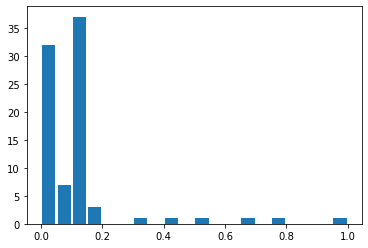

In [8]:
# How much missing data there is in each column of the dataset.
miss_percent_col=[round(gen_pop.iloc[:,[col]].isna().sum().values[0]/gen_pop.shape[0],2) for col in range(gen_pop.shape[1])];
plt.hist(miss_percent_col,bins=20,rwidth=0.85);

It is now time to undertand what kind of data feature more than, say, 40% of missing entries. Presumably, these features will be correlated. So first let us identify them by establishing a threshold of 20% of missing entries.

In [9]:
# Perform an assessment of how much missing data there is in each column of the dataset.
col_to_drop=[i for i in range(gen_pop.shape[1]) if gen_pop.iloc[:,[i]].isna().sum().values[0]/gen_pop.shape[0] > 0.2]
print(col_to_drop)

features_to_drop = [gen_pop.iloc[:,col_to_drop[i]].name for i in range(len(col_to_drop))]
print(features_to_drop)

[0, 11, 40, 43, 47, 64]
['ager_type', 'birth_year', 'academic_tit', 'alter_hh', 'cons_patt', 'pop_build']


In [10]:
# Investigate patterns in the amount of missing data in each column.
for i in range(len(features_to_drop)):
    print((features_to_drop[i],round(gen_pop.iloc[:,col_to_drop[i]].isna().sum()/gen_pop.shape[0],2)))

('ager_type', 0.77)
('birth_year', 0.44)
('academic_tit', 1.0)
('alter_hh', 0.35)
('cons_patt', 0.66)
('pop_build', 0.53)


In [11]:
# Removing the outlier columns from the dataset. 
gen_pop_col_dropped=gen_pop.drop(columns=features_to_drop)

Assessing Missing Data in Each Column: highlights

First let me provide the English translation of the features removed from the dataset, 
which is available from the '.md' data dictionary.

- Ager type 
- Birth  Year
- Academic Title Flag 
- Head of household birth date
- Consumer pattern in past 12 months
- Most common building type within the microcell

It seems to me that it is pretty reasonable that such personal or qualitative data should be among the most defective within the dataset, because these are informations which are presumably hard to obtain for a private company. 
Some of them may be searched for in census results, like the birth year. Though I am not privy to German privacy laws, I suspect that a private company would have a hard time accessing such census results.

It is likely that these data have been obtained collecting information in 3 basic ways (that I can think of at least):

0. Well, information about academic titles hasn't bee collected at all.


1. Directly from customers over the years, for instance by asking them to fill some necessary forms to initiate the commercial relationship; beside basic and necessary information, companies may have asked some non mandatory questions like birth year which have helped it identify features not directly related to the customer, like the birth date of the head of the household. The voluntary nature of one's birth year or the head-of-household's birth date disclosure make the data mining process harder, explaining why they are a bit defective. Beside, the fact that the amounts of missing data on these two features is comparable, is an indication that a persona inclined to disclose one is roughly equally inclined to disclose the other. 


2. Following up on this, companies may have put some data mining effort analysing and cross linking and checking data on neighborhoods or data on purchase patterns from the company itself to extract more qualitative features such as type of ager and consumer patterns in the past 12 months. The fact that the amount of missing data for these two features is comparable suggests that there is a correlation between them; secondly, they are also harder to mine, since more than 65% of entries is missing from both; finally, ager type is the more defective one.


3. Availability of information about the most common building type in the microcell is practically a coin toss, with roughly 50% of data being available. Since, however, for all other features about microcells more than 80% of data is collected, this is likely a problem of averaging and time-dependence: it is often possible to qualify the most common types of family homes in the neighborhood in terms of number of inhabitants, but selecting the most common one can be hard for a few reasons: defining the precise borders of such a microcell (averaging) and being sure that people haven't left their families to live elsewhere (or are going to do so soon) and that newborns are unlikely to arrive/are arriving soon (time dependence). In such cases, the data engineer's conservative choice to declare uncertainty in the form of missing data may be less biasing than selecting a feebly standing option.


To address the last question above: to know if columns share missing data, it is appropriate to look at patterns of missing data in rows, which is what we are going to do next. 

#### Assessing Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different number of missing values. We consequently divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. 
We thus select at least five of these columns and compare the distribution of values.

Depending on what we'll observe in your comparison, this will have implications on how we approach our conclusions later in the analysis or not. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data at the end.

In [12]:
# How much data is missing in each row of the dataset?
# I can run exactly the same analyis carried out for the dataset columns 
miss_percent_row=[gen_pop_col_dropped.iloc[[row],:].isna().sum(axis=1).values[0]/gen_pop_col_dropped.shape[1] for row in range(gen_pop_col_dropped.shape[0])];

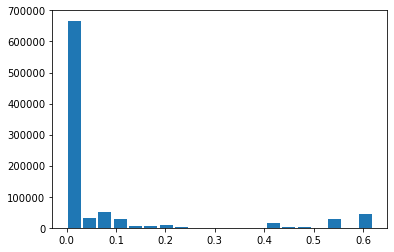

In [13]:
# Then we plot a histogram showing how percentages of missing data are distributed among dataframe rows 
plt.hist(miss_percent_row,bins=20,rwidth=0.85,label=str);

In [14]:
# Here I count the rows having more than 30% of missing entries: it is roughly 10% of all rows
rows_to_drop=[i for i in range(gen_pop_col_dropped.shape[0]) if miss_percent_row[i] > 0.3]
print(len(rows_to_drop),len(rows_to_drop)/gen_pop_col_dropped.shape[0])

93384 0.10478209108627377


In [15]:
# Writing code to divide the data into two subsets based on the number of missing values in each row.

gen_pop_all_dropped = gen_pop_col_dropped.drop(index=rows_to_drop)
gen_pop_all_dropped.reset_index(drop=True,inplace=True)

In [16]:
# ANSWER 2 
# Second, I should build a database made just of the rows which have been taken away
# I will take these rows from the gen_pop_col_dropped database, so that in both final 
# databases with less than 891221 rows
# I will have the same number of columns; in particular, the longer one will be the database # to be used for good.
gen_pop_rows_to_drop = gen_pop_col_dropped.iloc[rows_to_drop,:]

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# ANSWER 3:
# Since I have already dropped from both datasets the columns with >20% of missing entries,
# I can pick the first 5 columns of both of them and make the comparison
# To this end, let me write down a function which can make such a comparison after giving it column names
# But first let me check that, for instance, the first columns 3-7 of the dataset qualify (they do)
# If we choose these, which are all categorical, we can use the .countplot() method to plot them all

for i in range(3,8):
    print(gen_pop_col_dropped.iloc[:,[i]].columns.values.item(),gen_pop_col_dropped.iloc[:,[i]].isna().sum().values[0]/gen_pop_col_dropped.shape[0])

fin_min 0.0
fin_saver 0.0
fin_beprep 0.0
fin_inv 0.0
fin_incos 0.0


In [18]:
# With the function below, we can run a for loop over -for instance- all the ordinal 
# variables in the dataset to gauge how many of them feature different distributions 
# of data in the two row sets.

def compare_distributions(column,dataset1,dataset2,datat1_desc,datat2_desc):
    plt.figure(figsize=[18,5])
    plt.subplot(1,2,1)
    plt.title(datat1_desc)
    sns.histplot(x=column, data=dataset1, stat='probability', discrete=True);
    
    plt.subplot(1,2,2)
    plt.title(datat2_desc)
    sns.histplot(x=column, data=dataset2, stat='probability', discrete=True);
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()

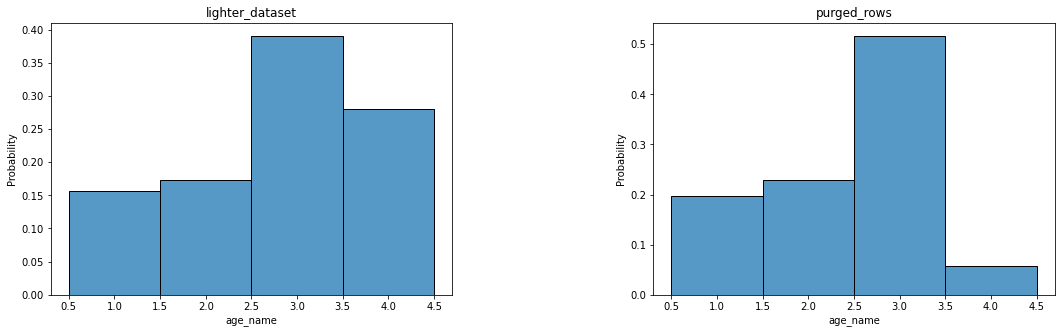

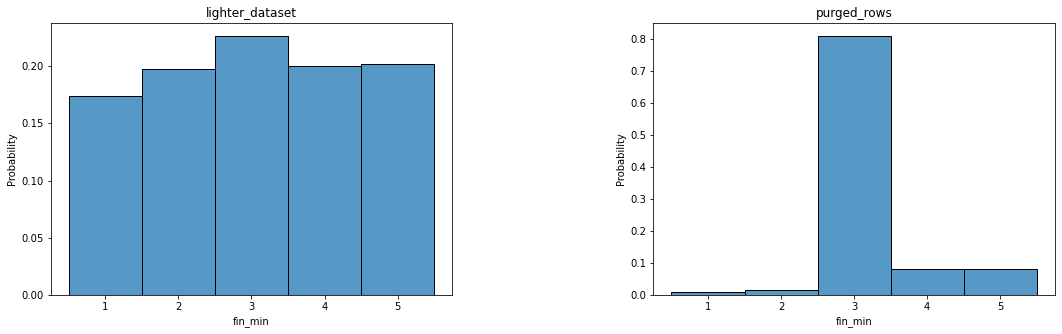

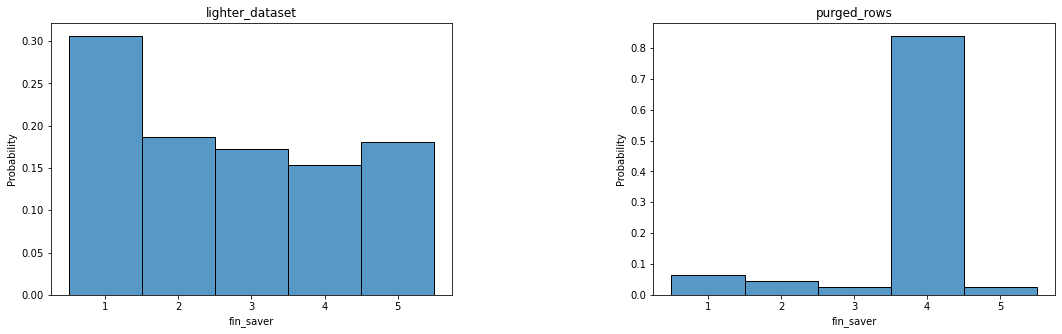

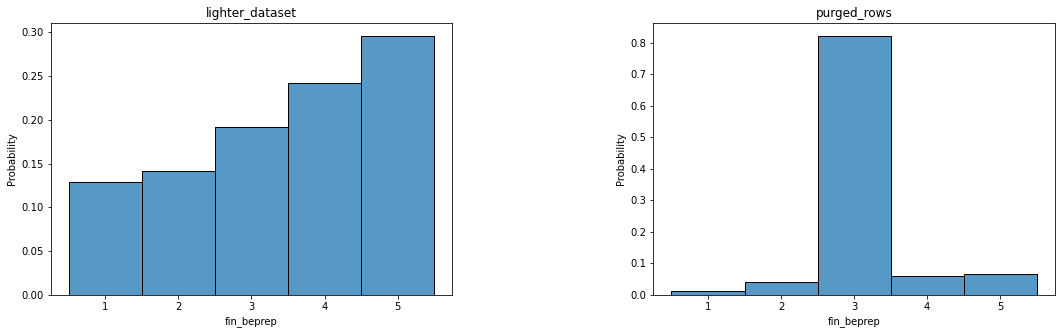

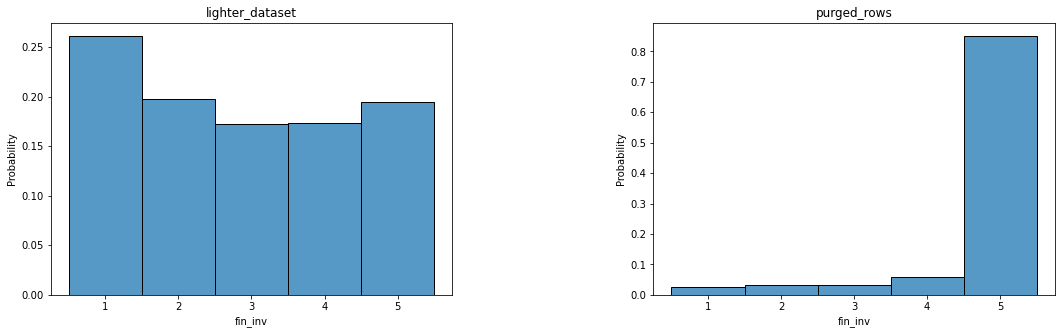

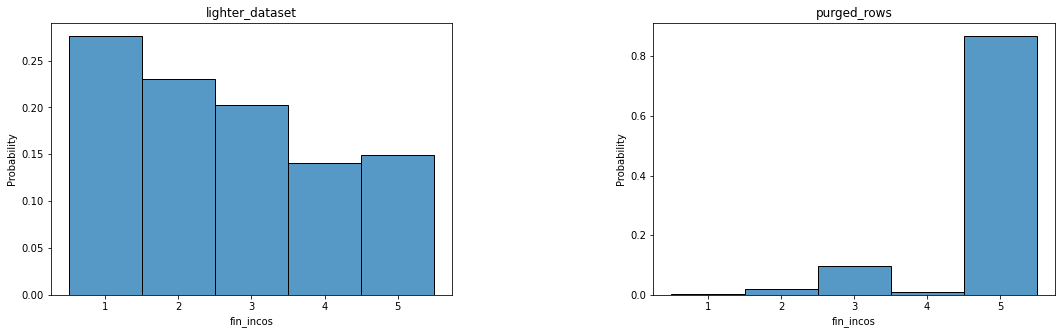

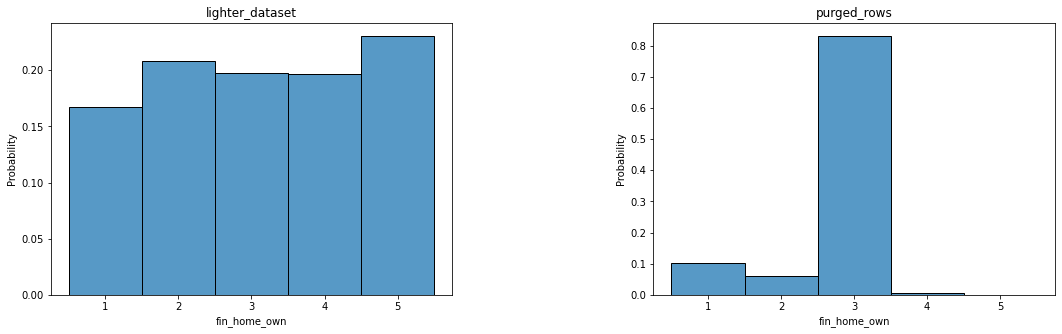

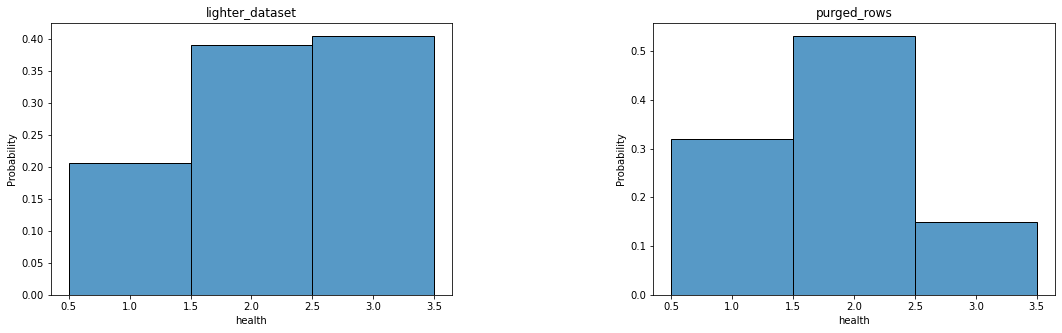

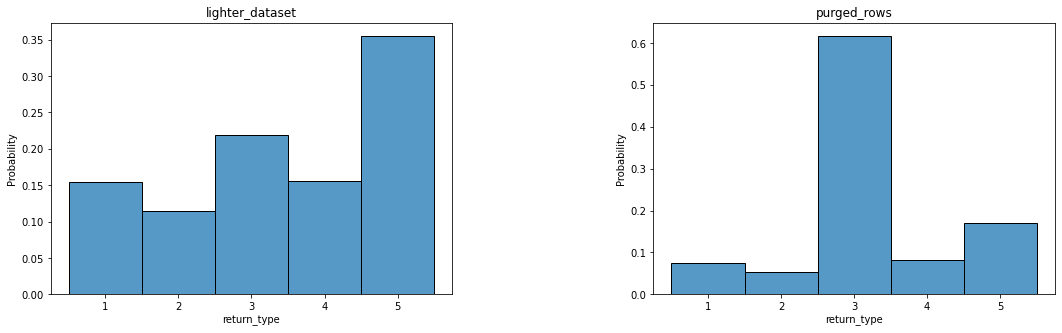

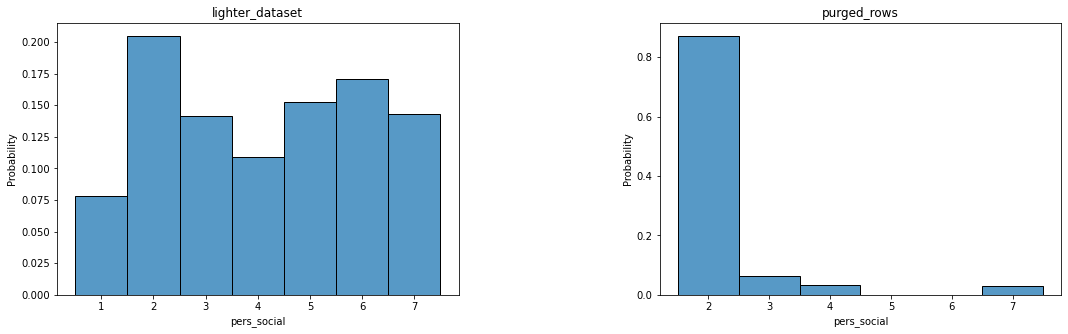

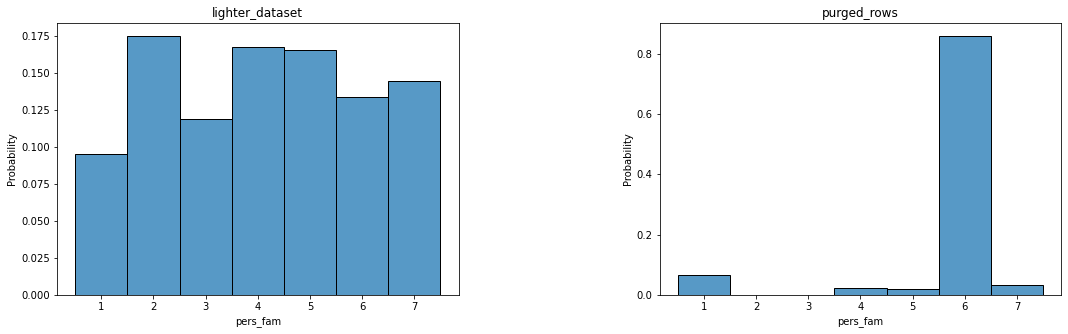

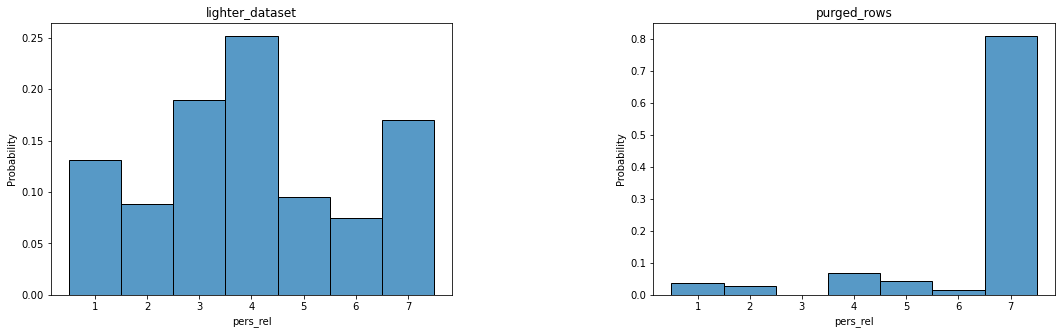

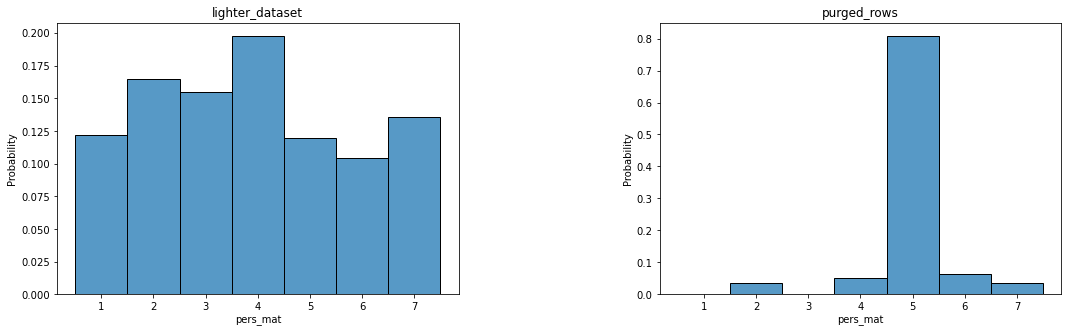

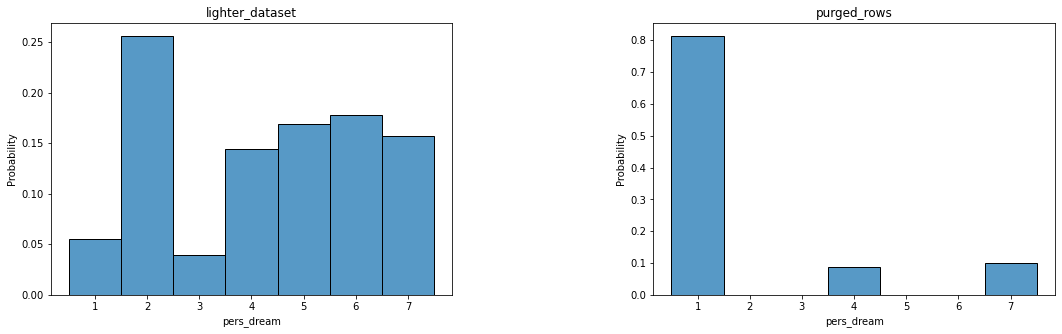

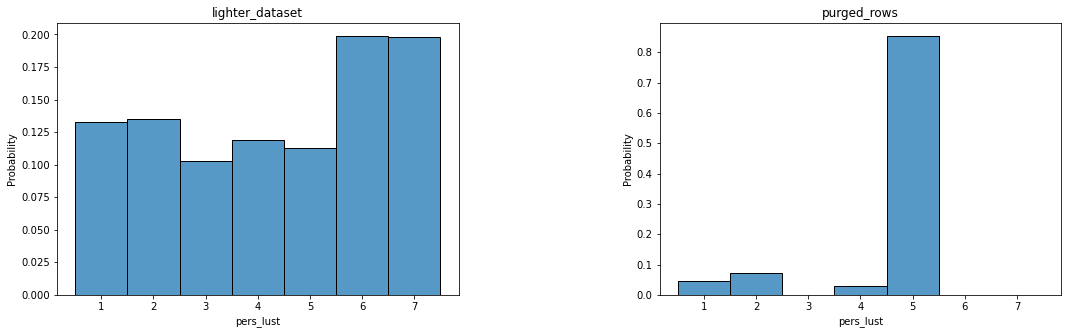

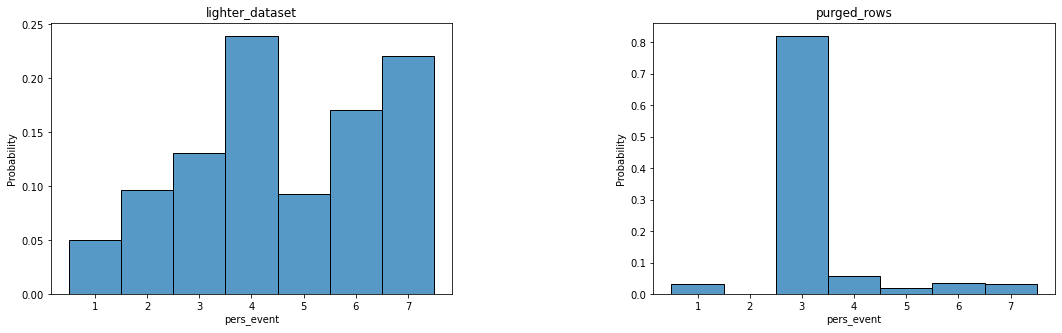

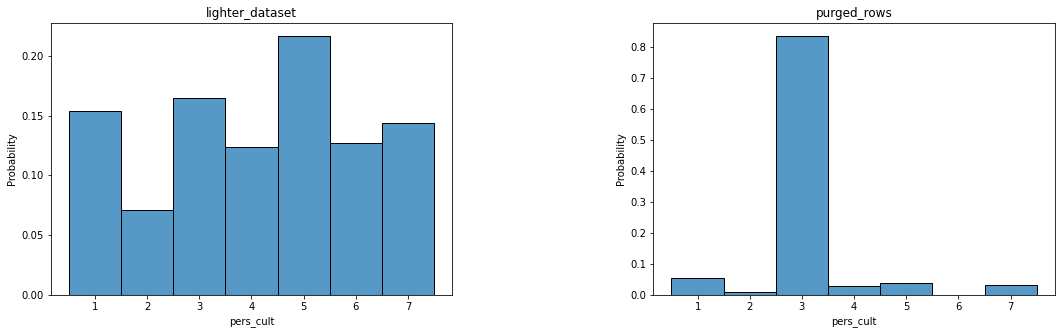

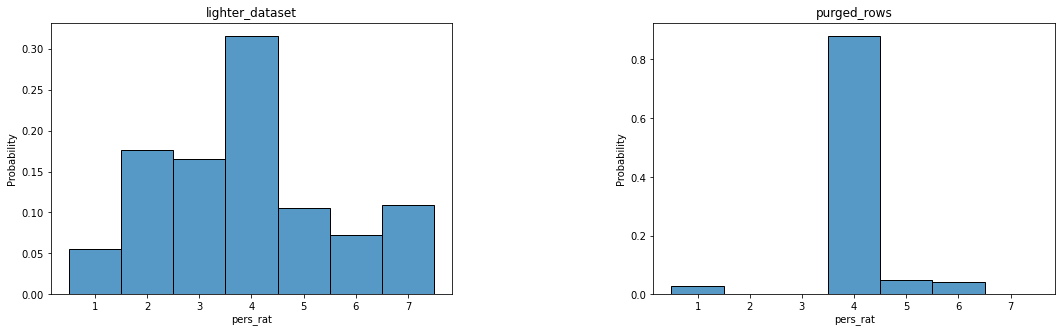

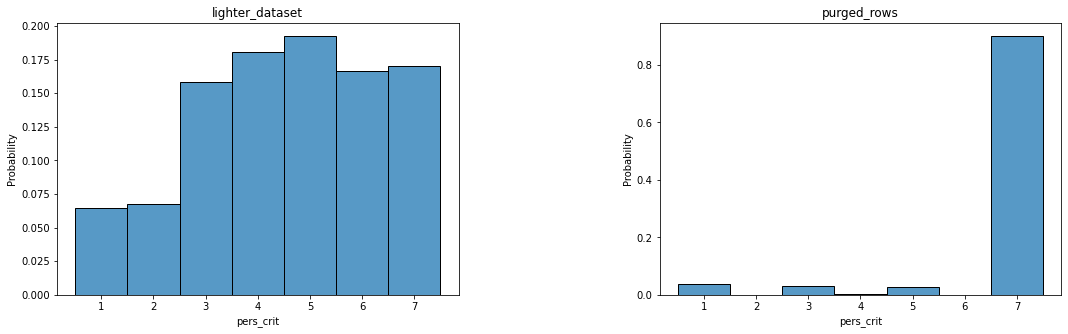

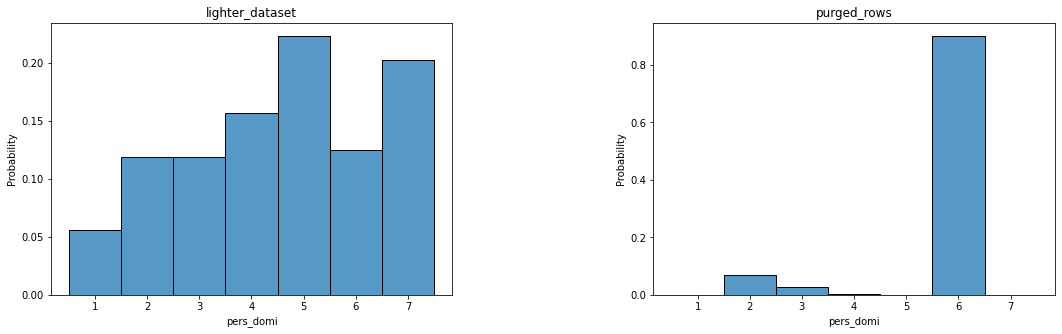

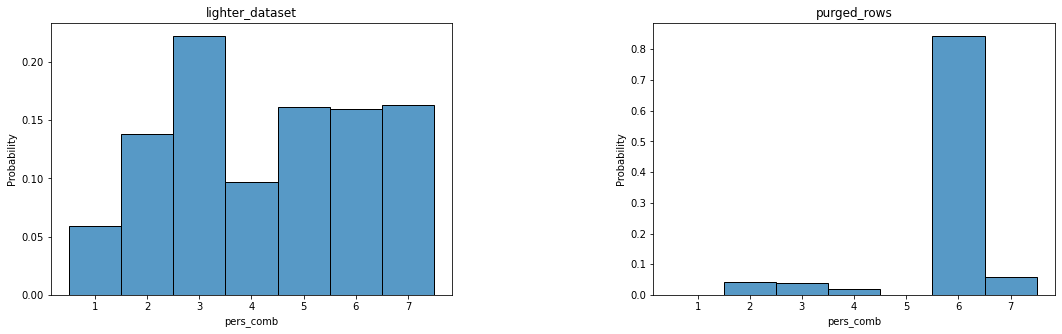

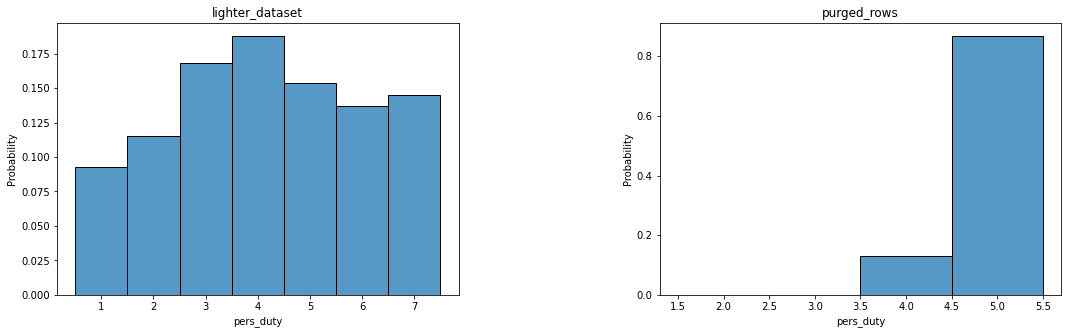

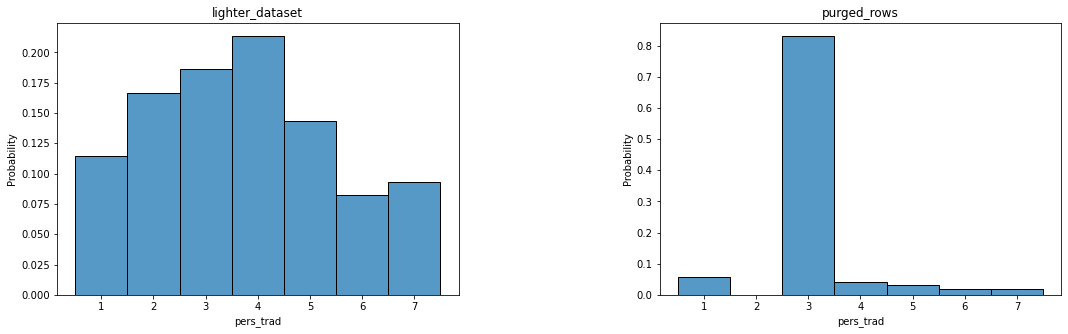

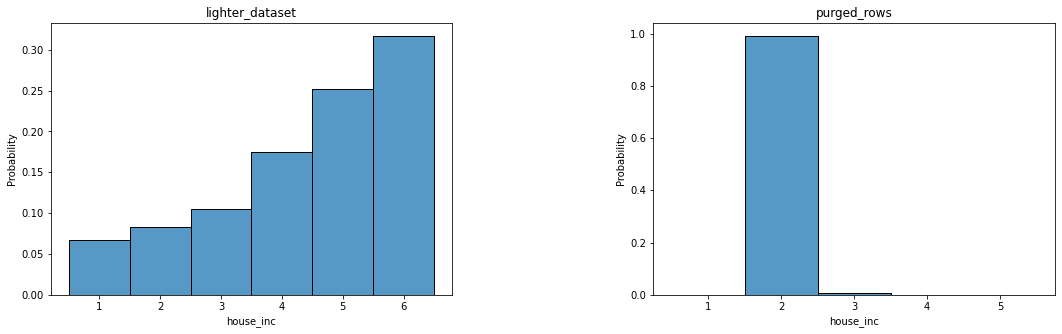

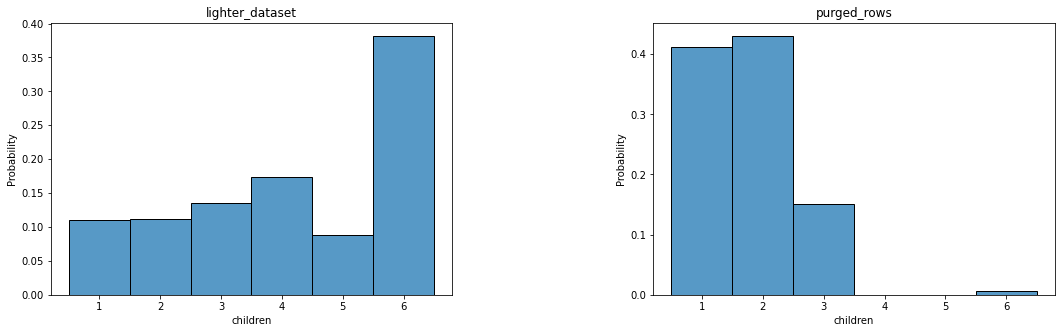

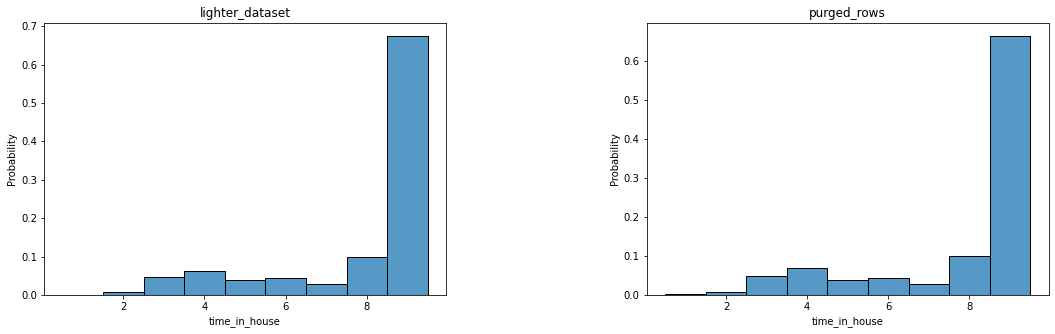

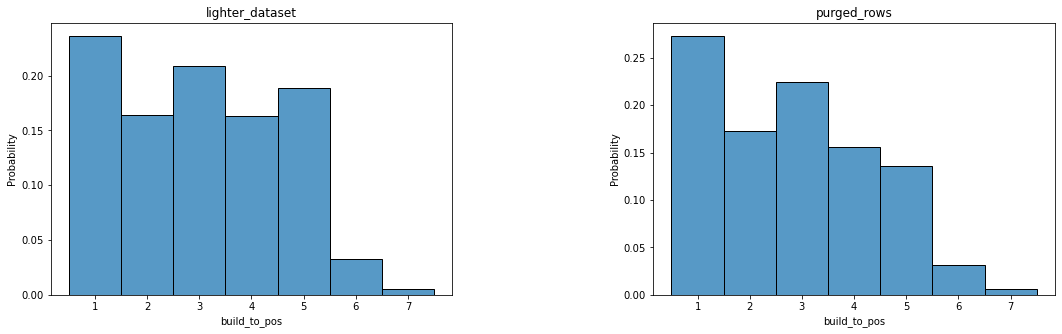

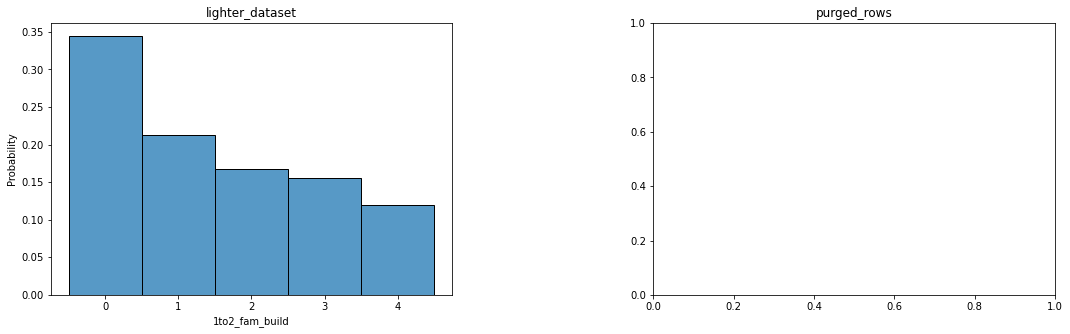

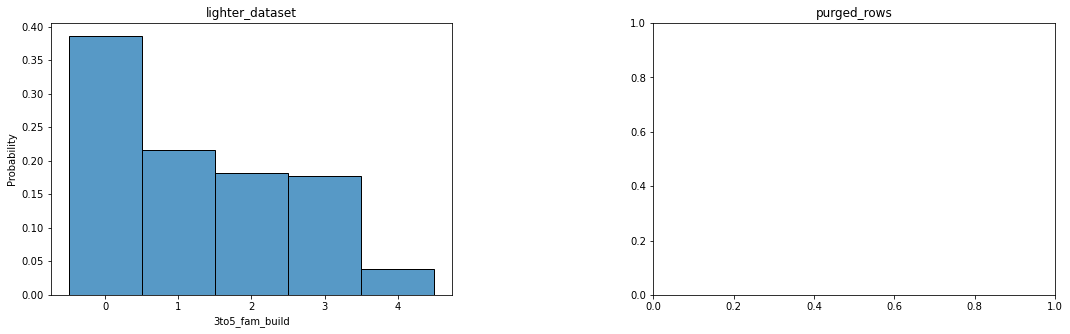

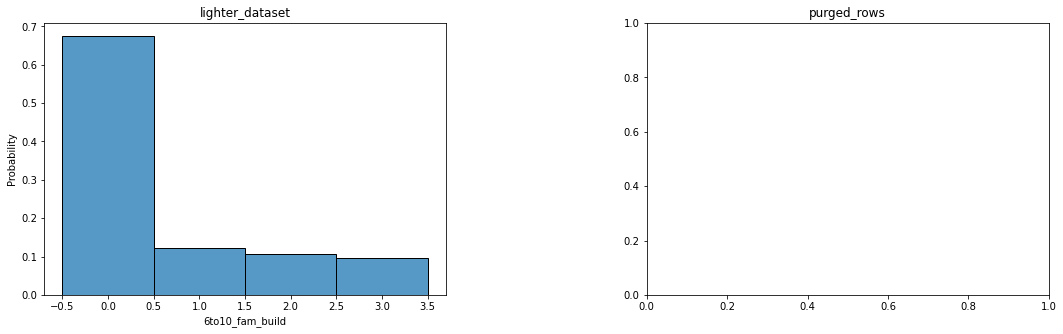

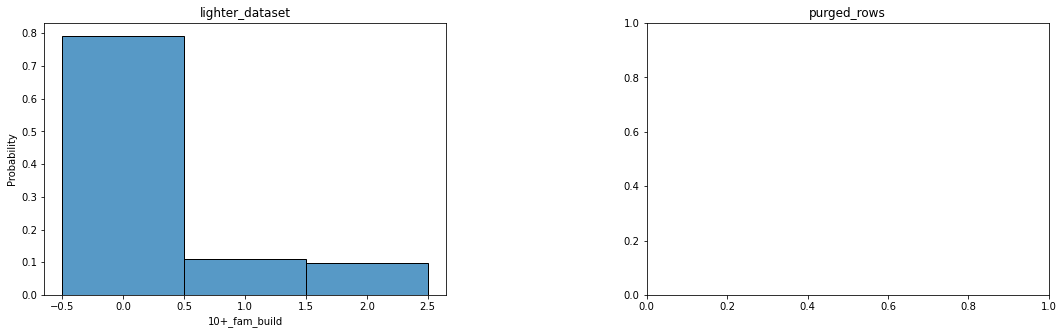

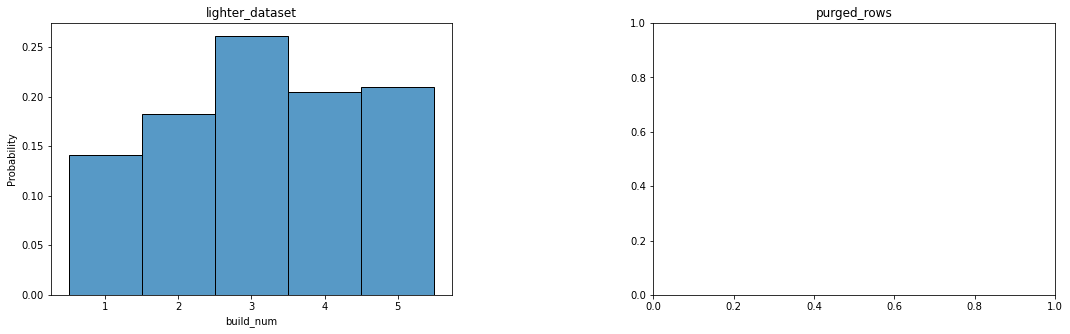

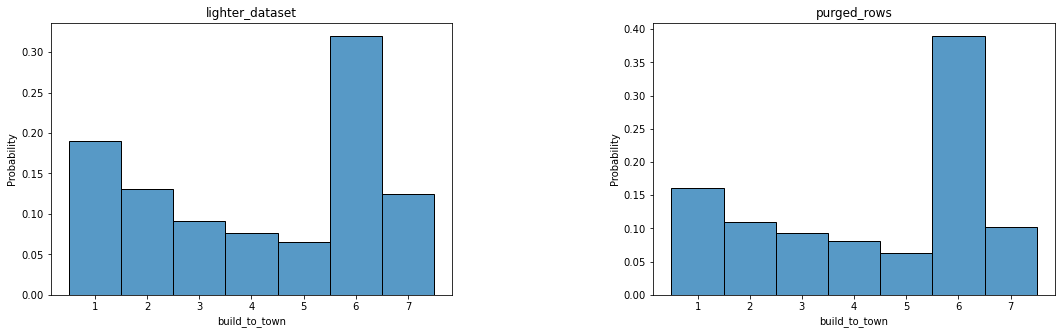

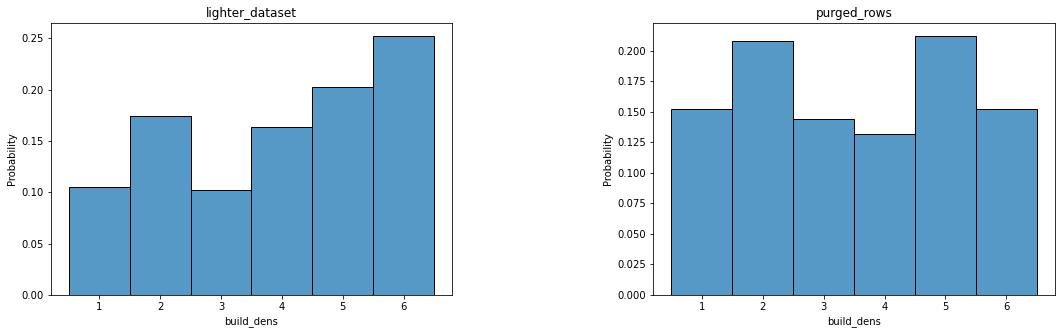

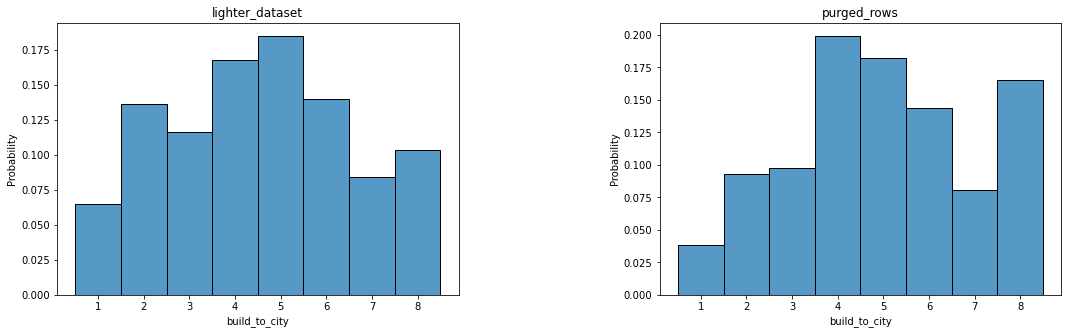

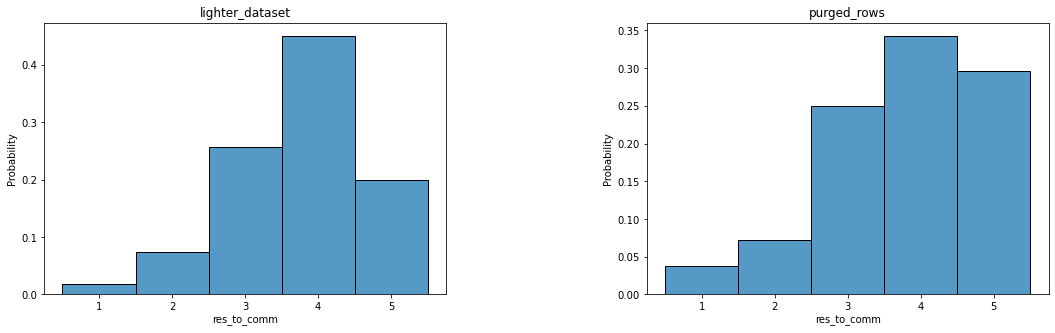

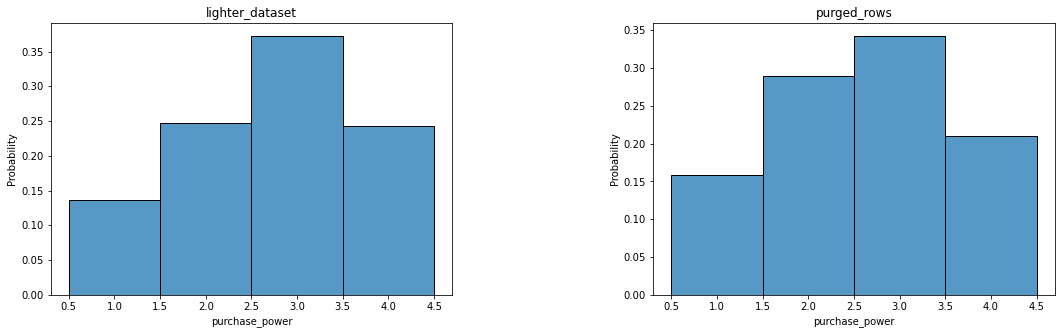

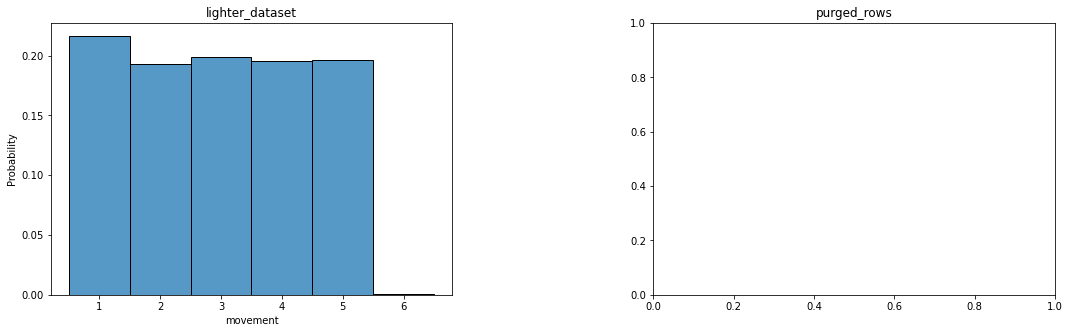

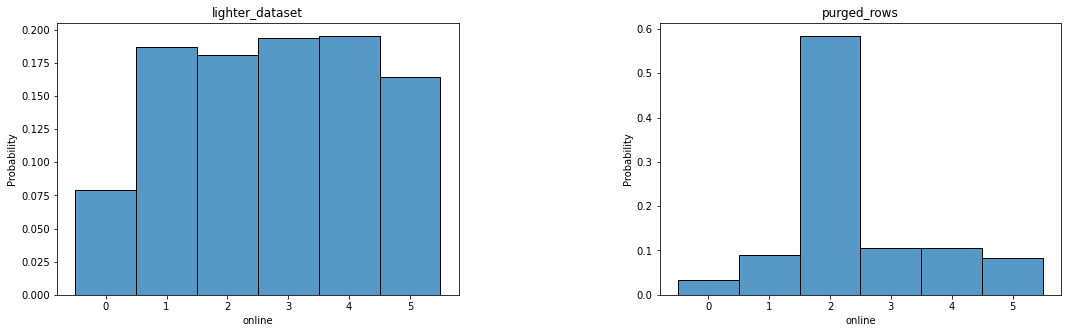

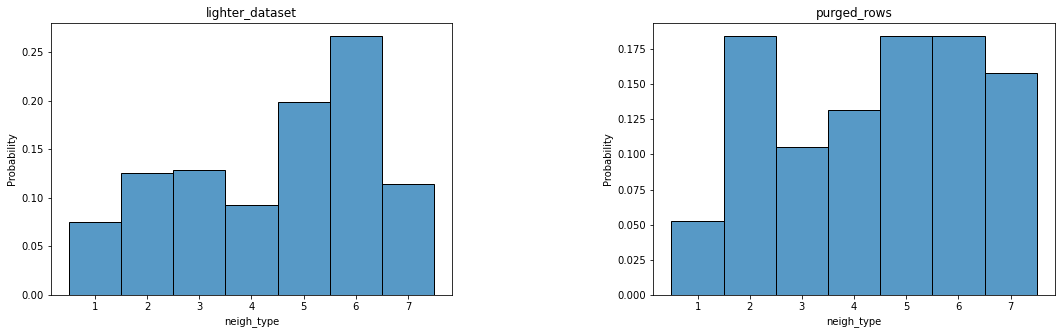

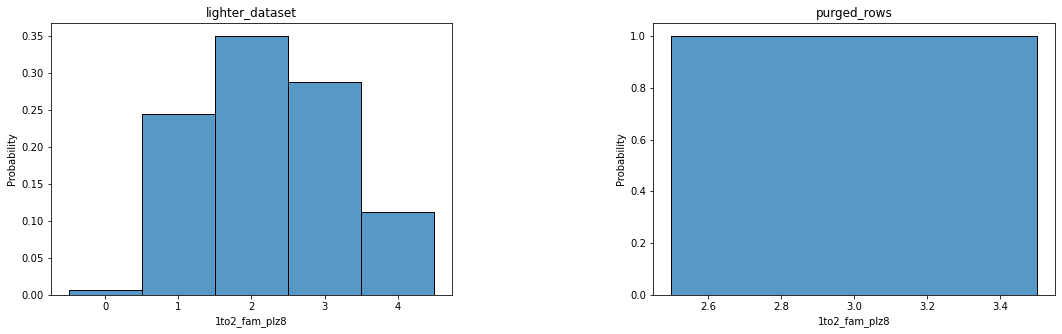

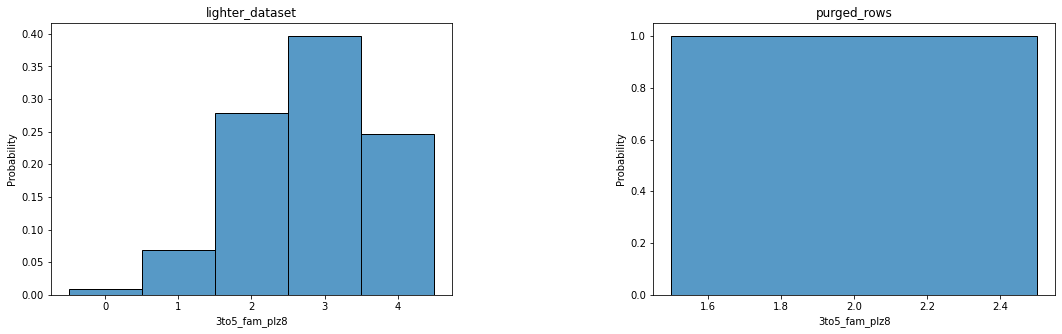

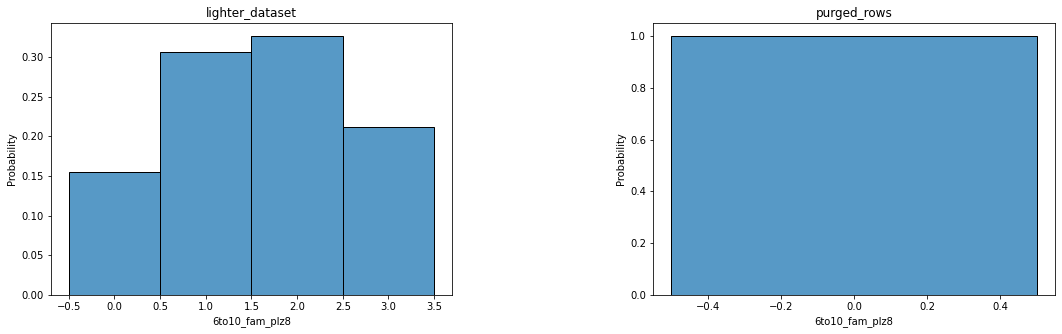

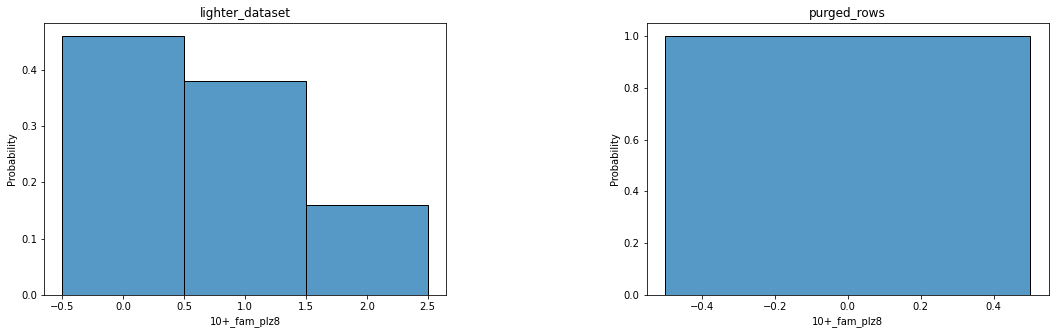

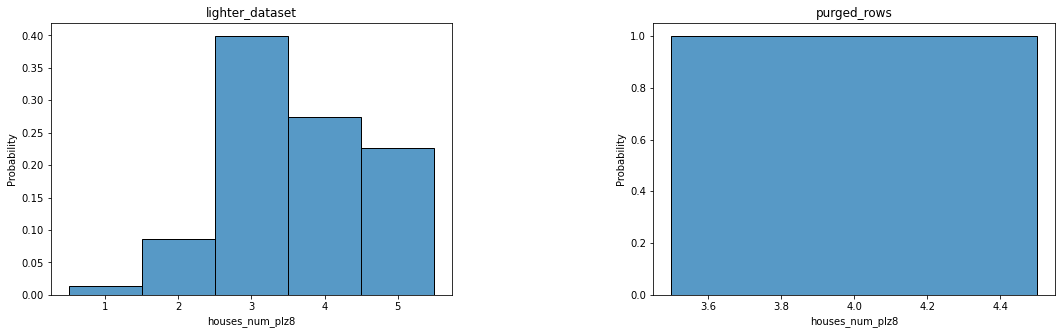

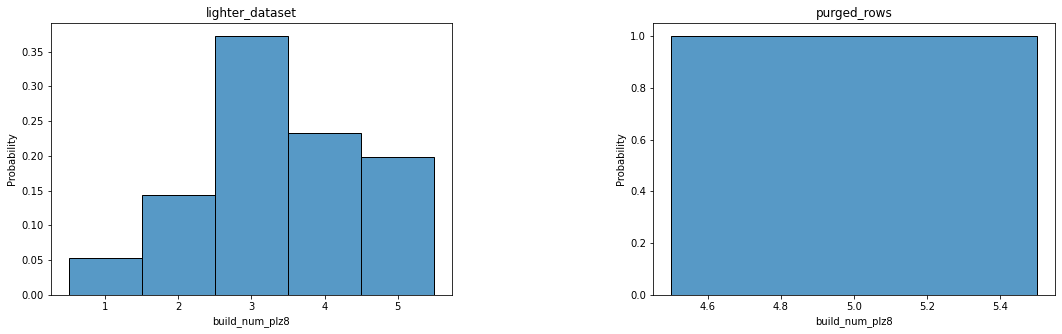

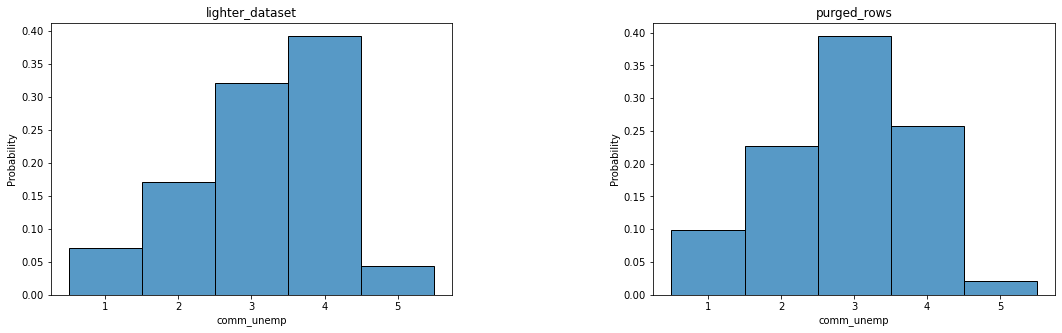

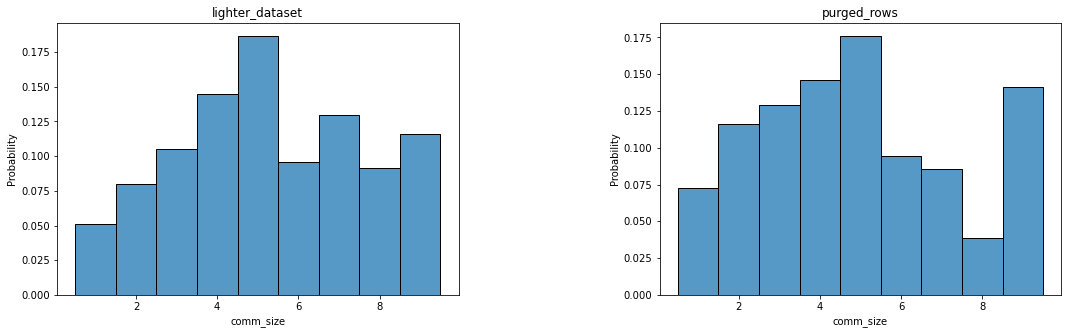

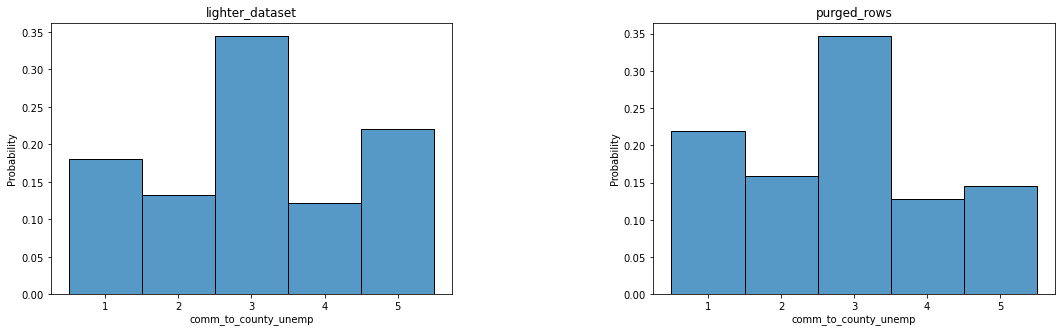

In [19]:
# We make the requested comparison for ordinal variables

for i in range(79):
    if feat_info[feat_info['attribute']==gen_pop_all_dropped.iloc[:,[i]].columns.values.item()].type.item()=='ordinal':
        compare_distributions(gen_pop_all_dropped.iloc[:,[i]].columns.values.item(),gen_pop_all_dropped,gen_pop_rows_to_drop,'lighter_dataset','purged_rows')

#### Assessing Missing Data in Each Row

There are some variables for which the data distribution among the two sets of rows is quite similar.
But there are many others where there is a blatant difference between the data in the rows we have kept and those in the rows we have omitted. The first ones which strike one's attention are financial situation indicators, starting with the second ordinal variable.

More specifically, we can see from the pair of histograms concerning the financial incospicousness of individuals in the dataset, that rows containing many missing data distinctively refer to individuals with significantly incospicuous financial status. 

### Selecting and Re-Encoding Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.

- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).

- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [20]:
# We first drop from feat_info the attributes that have been dropped from the "gen_pop" database
feat_info_all_dropped = feat_info.drop(index=col_to_drop)

# How many features are there of each data type ?
feat_info_all_dropped['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Re-Encoding Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. 
Depending on the number of categories, perform one of the following:

- For binary, numerical categorical features that take numeric values, we can keep them without needing to do anything.

- For multi-level categorical variables or a possible binary non numerical variable (we found one), we can choose to encode the values using multiple dummy variables.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and which ones needs to be re-encoded?

# The following shows the requested information, beside the fact that
# 'build_east_west' is the binary variable taking on non numeric values

cat_idx=list(feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'].index)

for i in cat_idx:
    print(gen_pop_all_dropped[feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][i]].value_counts())

2    416053
1    381784
Name: gender, dtype: int64
4.0    198266
3.0    147191
2.0    141253
5.0    111095
6.0    102065
1.0     93301
Name: customer_typ, dtype: int64
6    289041
1    197088
5    106315
2    104737
4     55915
3     44741
Name: fin_typ, dtype: int64
12.0    130207
10.0    102818
8.0      83026
11.0     75095
5.0      70497
4.0      60421
9.0      57121
3.0      53101
1.0      50654
2.0      43816
7.0      40678
6.0      25737
Name: vac_hab, dtype: int64
0    622640
1    175197
Name: green_avan, dtype: int64
1.0     402524
10.0    128962
2.0      98547
11.0     48744
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: family_type_F, dtype: int64
1.0    402524
5.0    188158
2.0     98547
4.0     49881
3.0     27429
Name: family_type_R, dtype: int64
1.0     206847
9.0     136342
10.0    111572
2.0     111089
4.0      73965
3.0      68915
6.0      28892
5.0      27575
8.0      18771
7.0       9203
Name: social_sta

In [22]:
# Here we create the lists by identifying the features which have more than 2 values
# and signing them up for encoding. 

# In the meanwhile, we turn the East-West-Germany binary categorical variable into a binary numeric one 
gen_pop_all_dropped.build_east_west.replace(to_replace=['O','W'],value=[0,1],inplace=True)

# List of variables needing encoding
need_encod=[i for i in cat_idx if len(gen_pop_all_dropped[feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][i]].value_counts()) >2];

In [23]:
# Here is the list of feature labels to be encoded
to_be_encoded=list(feat_info_all_dropped[feat_info_all_dropped['type']=='categorical']['attribute'][need_encod])

In [24]:
# And here we actually encode these categorical features
gen_pop_encoded = pd.get_dummies(gen_pop_all_dropped,columns=to_be_encoded)

So far, we have decided to keep all categorical features. 

The data engineering steps performed so far have consisted in 

1. identifying categorical variables

2. determining variables needing re-econding, either because they are not binary or because they are binary but  not numerical;

3. one-hot-encoding these variables via the Pandas method .get_dummies()

#### Engineering Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# In order to create the binary variable out of 'PRAEGENDE_JUGENDJAHRE', we first set up
# lists, looking at the data dictionary, of the values corresponding to Mainstream or 
# Avantgarde then we se up a list for the decaded
mainstream_entries=[1,3,5,8,10,12,14]
avantgarde_entries=[2,4,6,7,9,11,13,15]
decade_entries=[40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]

# Function extracting youth decade
def youth(obj,list):
    if pd.isnull(obj) == False:
        return list[int(obj)-1]

In [26]:
# Engineering the person's youth decade 
# (German translation courtesy of Google Translate)
gen_pop_encoded['youth_decade']=gen_pop_encoded.youth_ideology.apply(youth,args=(decade_entries,))

In [27]:
# Ideological movement function
def movement(obj,mov_1,mov_2):
    if pd.isnull(obj) == False:
        if int(obj) in mov_1:
            return 0
        elif int(obj) in mov_2:
            return 1

In [28]:
# Engineering the ideological movement charachterising the person's youth 
# (German translation courtesy of Google Translate)
gen_pop_encoded['dominidea_as_youngster']=gen_pop_encoded.youth_ideology.apply(movement,args=(mainstream_entries,avantgarde_entries))

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables

# This is more immediate, it just boils down to separating decimal places
# Function to isolate the wanted decimal place and turn it into a number
def int_split(string,i):
    if pd.isnull(string)==False: 
        return string[i]

# German translation of wealth level and family structure courtesy of Google Translate 
gen_pop_encoded['wealth']=gen_pop_encoded.cameo_int.apply(int_split,args=(0,))
gen_pop_encoded['family_structure']=gen_pop_encoded.cameo_int.apply(int_split,args=(1,))

In [30]:
feat_info_all_dropped[feat_info_all_dropped['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,life_stage_F,person,mixed,[0]
16,life_stage_R,person,mixed,[0]
22,youth_ideology,person,mixed,"[-1,0]"
56,neighbors,building,mixed,[-1]
59,cameo_int,microcell_rr4,mixed,"[-1,XX]"
79,pop_build_plz8,macrocell_plz8,mixed,"[-1,0]"


Now we must turn our attention to the remaining mixed type variables which are still left
and whose information we mean to keep (see section below for details).  
We start with WOHNLAGE, which stands for neighborhood quality.

In [31]:
# We have to engineer a new variable which flags the neighborhood as rural or not (1,2 vs 0)
# and distinguishes newer (2) from older houses (1) 
# Its value is NaN if the record was not taken

def rural_var(obj,list_1,list_2,list_3,list_4):
    if pd.isnull(obj) == False:
        if obj in list_1:
            return np.nan
        elif obj in list_2:
            return 0
        elif obj in list_3:
            return 1
        elif obj in list_4:
            return 2

gen_pop_encoded['house_quality']=gen_pop_encoded.neighbors.apply(rural_var,args=([0],[1,2,3,4,5],[7],[8]))

In [32]:
# And this is the second new variable, which we set to NaN if the quality of the home is not measured
# or if the latter is in a rural area, otherwise it keeps the 5 ordinal values for the urban classification
# This is meant to keep things simpler

def neigh_qual(obj,list_1,list_2):
    if obj in list_1:
        return obj
    elif obj in list_2:
        return np.nan

gen_pop_encoded['neighbor_quality']=gen_pop_encoded.neighbors.apply(neigh_qual,args=([1,2,3,4,5],[0,7,8]))

Now is the turn of PLZ8_BAUMAX, a variable which we also want to split into two new variables: a binary variable to tell business area from residential areas and the other one to distinguish the four remaining categories of residential areas based on the most common range of numbers of families living within the microcell. 

In [33]:
# This is a function to create the binary variable
def binary_business(obj,list_1,list_2):
    if obj in list_1:
        return 0
    elif obj in list_2:
        return 1


gen_pop_encoded['buss_vs_res']=gen_pop_encoded.pop_build_plz8.apply(binary_business,args=([1,2,3,4],[5]))

# Here come another simple function to create the categorical variable 
# in the event that the area is residential

def fam_num(obj,list_1,list_2):
    if obj in list_1:
        return obj
    elif obj in list_2:
        return 0

gen_pop_encoded['resid_type']=gen_pop_encoded.pop_build_plz8.apply(fam_num,args=([1,2,3,4],[5]))

In [34]:
gen_pop_encoded.drop(columns=['youth_ideology','cameo_int','neighbors','pop_build_plz8','life_stage_F','life_stage_R'],inplace=True)

As for 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015', we have performed the steps outlined above.

This leaves 4 additional mixed type features among those with sufficient data. 
Namely, what I have done has been the following:

- LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, i.e.
  fine grained or more coarse aggregated information about life stage and weath of people.
  I decided to drop these them: first of all, they contain a lot of redundant information: 
  for instance, people's wealth is recorded in
  CAMEO_INTL_2015, which we have already disentangled.

- WOHNLAGE, i.e. neighborhood quality or rural flag and I decided to add a binary variable
  which carachterizes the neighborhood ar rural or not, while keeping the remaining
  information within another variable for city households.

- PLZ8_BAUMAX, i.e. most common number of families within one building or business buildings,
  led me to a similar choice: I created a new binary variable which charachterizes the area
  as business area or not and kept the remaining information about the most common number of families
  in any given building within the microcell in another variable.

#### Completing Feature Selection

In order to complete this step, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

We'll make sure to remove the parents of the new features from the final data frame.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Looking at the mixed type features which had survived data dropping,
# we can see below that the 6 mixed type features have been takien care of above 

feat_info_all_dropped[feat_info_all_dropped['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,life_stage_F,person,mixed,[0]
16,life_stage_R,person,mixed,[0]
22,youth_ideology,person,mixed,"[-1,0]"
56,neighbors,building,mixed,[-1]
59,cameo_int,microcell_rr4,mixed,"[-1,XX]"
79,pop_build_plz8,macrocell_plz8,mixed,"[-1,0]"


In [36]:
# I order to ensure thatth dataframe contains the correct number of features,
# we can create a new feature summary which does not see them and includes, on the other hand,
# the newly created variables
feat_info_all_dropped_nomixed=feat_info_all_dropped.drop(index=[15,16,22,56,59,79])

# We can create a new database with the 8 newly engineered features

feat_info_new_mixed = {
'attribute' : ['youth_decade','dominidea_as_youngster','wealth','family_structure','house_quality','neighbor_quality','buss_vs_res','resid_type'],
'information_level': ['person','person','microcell_rr4','microcell_rr4','building','building','microcell_plz8','microcell_plz8'] ,
'type': ['categorical','categorical','categorical','categorical','categorical','categorical','categorical','categorical'],
'missing_or_unknown': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
}

new_feat = pd.DataFrame(feat_info_new_mixed)

feat_info_final = feat_info_all_dropped_nomixed.append(new_feat)

In [37]:
# Now I should check that the number of features I have dropped initially plus the 6 mixed type ones I have re-engineered minus the 8 new ones is equal to the difference between the rows of feat_info and feat_info_final

feat_info.shape[0]-feat_info_final.shape[0]-(len(col_to_drop)+6-8)

0

### Creating a Cleaning Function

Even though we are done cleaning up the general population demographics data, it's important to look ahead to the same cleaning steps to be performed on the customer demographics data. 

Thus we write down a function to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [85]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data    
    INPUT: Demographics DataFrame OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Comment 1: I am assuming I can include the feat_info metadata table as an argument to the
    # function, unless I can just take it from outside the function itself to stick to the 
    # single argument prescriptions above...in either case, I need the info abou the 'missing or unknown'
    # data which is stored in the feat_info

    # PUT IN THE CODE HERE TO EXECUTE ALLA MAIN CLEANING STEPS:
    
    # convert issing values into Numpy NaN 

    for f in np.array(df.columns):
        for miss in [0,-1,9,'X','XX']:
            if re.search(str(miss),feat_info[feat_info['attribute']==f]['missing_or_unknown'].values[0]):
                df[f].replace(miss,np.nan,inplace=True)
    
    print(df.shape[0])
    df.replace('[]',np.nan,inplace=True)
    # remove selected columns and rows...
    df_col_dropped=df.drop(columns=features_to_drop)
    # Here I count the rows having more than 30% of missing entries
    percent_row=[df_col_dropped.iloc[[row],:].isna().sum(axis=1).values[0]/df_col_dropped.shape[1] for row in range(df_col_dropped.shape[0])];
    rows_to_drop=[i for i in range(df_col_dropped.shape[0]) if percent_row[i] > 0.3]
    
    # This line of code will be necessary in the final step, 
    # to account for the number of rows left apart because of missing values in a separate cluster
    
    df_all_dropped=df_col_dropped.drop(index=rows_to_drop)
    df_all_dropped.reset_index(drop=True,inplace=True)
    
    # binary non numerical variable being replaced by a numerical one
    df_all_dropped.build_east_west.replace(to_replace=['O','W'],value=[0,1],inplace=True)

    # We encode categorical features
    df_encoded = pd.get_dummies(df_all_dropped,columns=to_be_encoded)
    
    # Now we use the functions  defined in the encoding section of part I
    # to disentangle mixed variable 
    
    # Disentangling mixed variables and removing, in the end, their mother variables

    df_encoded['youth_decade']=df_encoded.youth_ideology.apply(youth,args=(decade_entries,))
    df_encoded['dominidea_as_youngster']=df_encoded.youth_ideology.apply(movement,args=(mainstream_entries,avantgarde_entries))
    df_encoded['wealth']=df_encoded.cameo_int.apply(int_split,args=(0,))
    df_encoded['family_structure']=df_encoded.cameo_int.apply(int_split,args=(1,))
    df_encoded['house_quality']=df_encoded.neighbors.apply(rural_var,args=([0],[1,2,3,4,5],[7],[8]))
    df_encoded['neighbor_quality']=df_encoded.neighbors.apply(neigh_qual,args=([1,2,3,4,5],[0,7,8]))
    df_encoded['buss_vs_res']=df_encoded.pop_build_plz8.apply(binary_business,args=([1,2,3,4],[5]))
    df_encoded['resid_type']=df_encoded.pop_build_plz8.apply(fam_num,args=([1,2,3,4],[5]))
            
    df_encoded.drop(columns=['youth_ideology','cameo_int','neighbors','pop_build_plz8','life_stage_F','life_stage_R'],inplace=True)
    
    # RETURN THE ENCODED DATAFRAME.
    return df_encoded

## Step 2: Feature Transformation

### Applying Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In this substep, we must be aware of the following:

sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, we make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an imputer.

In [39]:
# If you've not yet cleaned the dataset of all NaN values, 
# then investigate and do that now.

# We see that 39% of data points (more than one in three) feature some missing values. 
# Simply removing them is definitely going to bias the estimates of some parameters,
# so outright deleting rows with missing values is not the way
gen_pop_encoded.isna().any(axis=1).sum()/gen_pop_encoded.shape[0]

0.3905171106378872

In [40]:
# As we can see, in the vast majority of rows there are very few missing values.
gen_pop_encoded.isna().sum(axis=1).value_counts();

In [41]:
# Beside, in nearly all columns the percentage of missing data is negligible: 
# below one can see that columns with many missing values are rare (actually, only one has # an order of magnitude of missing values comparabe to the number of rows)
gen_pop_encoded.isna().sum(axis=0).value_counts()

0         157
23132       8
39940       6
592         3
36644       2
28673       2
64718       2
6069        2
4224        2
4666        2
7           1
6413        1
4123        1
6862        1
59177       1
2800        1
193609      1
12474       1
3810        1
70          1
dtype: int64

In [42]:
# We conclude that using an imputer replacing missing values with most frequent ones 
# on the gen_pop_encoded dataset is fine

# So here we go, applying the imputer to our dataframe
imp_most=SimpleImputer(missing_values=np.nan,strategy='median')
gen_pop_imputed=imp_most.fit_transform(gen_pop_encoded)

In [43]:
# Applying feature scaling to the general population demographics data.
std_scal=StandardScaler(with_mean=True,with_std=True)
gen_pop_scaled=std_scal.fit_transform(gen_pop_imputed)

As explained in the comments above, what jumps to one's attention is

1- there are too many rows with missing data (39%) to simply remove them before scaling.
   Please notice: this id very different from what we investigated in part I: there, we dropped
   rwos with more than 30% of missing values. Here we are considering rows with ANY number of missing values.

2- most of these rows have very few missing values, which means that they will affect only a few columns

3- the missing data are quite sparse across columns, i.e. there is a very limited amount of columns with a significcant amount of missing data. 

These considerations lead us to decide to impute NaNs entries by replacing them with the fuature's median value.

In [44]:
### We are now finally ready to employ dimensionality reduction techniques. 

In [55]:
# First we take a slighty modified version of the function in the nanodegree pca practice
# in order to inestigate the variance accounted for by each component individually 
# as well as the cumulative one

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12, rotation=90)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


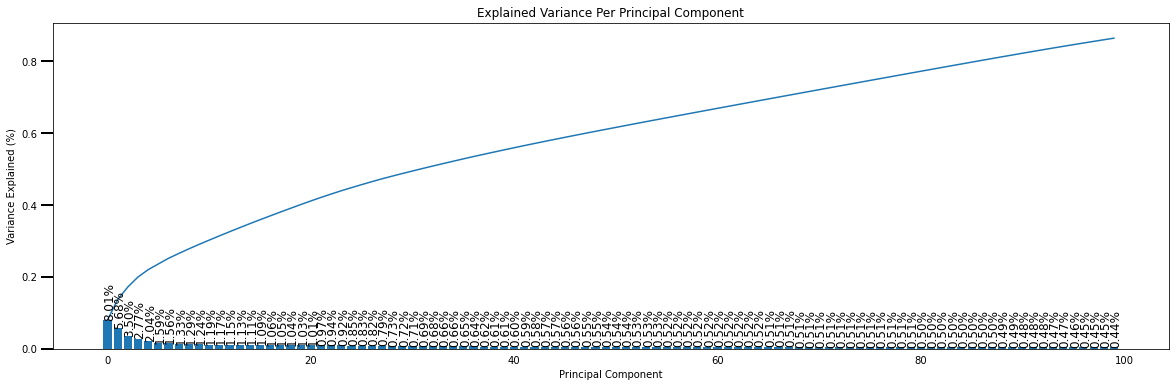

In [56]:
# Apply PCA to the data.
pca100 = PCA(100)
gen_pop_pca = pca100.fit_transform(gen_pop_scaled)
# Investigate the variance accounted for by each principal component.
scree_plot(pca100)

In [57]:
pca100.explained_variance_ratio_.sum()

0.8643240998592427

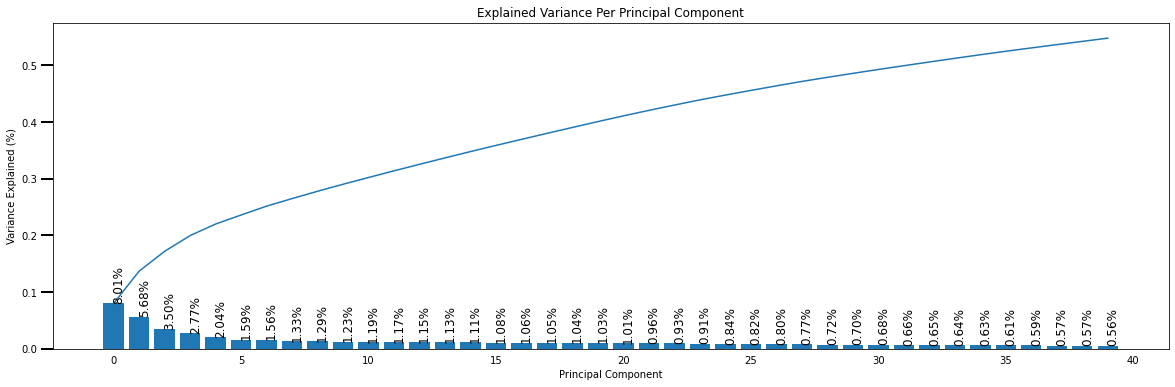

In [58]:
# Re-apply PCA to the data while selecting for number of components to retain
pca40 = PCA(40)
gen_pop_pca40 = pca40.fit_transform(gen_pop_scaled)
# Investigate the variance accounted for by each principal component.
scree_plot(pca40)

In [59]:
pca40.explained_variance_ratio_.sum()

0.5481974046342879

After performing pca with 100 features, i.e. with roughly half the inizial number of features, we ralised that, after the first 35 ones, 55% of the variance is retained and, after the first 40, the overall variance is roughly 60%, whereas the incremental variance accounted for by every other one is equal to or less than 0.6%.

Even though, by scouring online resources, such as Andrew Ng's videos of his Introduction to Machine Learning course, we have come to know that a common rule of thumb used in the community is to keep as many pca components as it is necessary to preserve at least 85% of the variance, we have also asked ourselves whether this rule should be completely general or rather, in the cases such as the one we are facing, where each individual component after the first n (with roughly n=40) brings such little incremental knowledge about the variance, we should just focus on more conspicuous components, which are more likely to bring less noisy information. In other words, is the additional variance accounted for by sub-dominant components not essential, i.e. not really charachterising essential features of the statistical sample in the dataframe ?

This is supported by a simple observation made during the course: in the PCA_MNIST exercise, an accuracy greater than 90% in handwritten digits recognition is achieved by the random forest classifier staying with just 29 principal components, which together account for just 50% of the variance: another instance where additional components bring about a lot of noise which is not decisive. 

Therefore, we decided to try to keep just the first 40 features, considering that, though it may be true that the general rule of thumb is to go for a much higher variance, ths might not hold when the contribution of sub-dominant features is below a certain threshold, for it could be like trying to squeeze meaningful information out of noise.     

### Interpreting Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [60]:
# HERE WE BUILD THE FUNCTION WHICH RETURNS THE ORDERED LIST OF FEATURE NAMES

# The last dataframe containing populations data is named was gen_pop_encoded 
# Subsequent scaling and imputing operations turned it into an array
# Therefore, we retrieve columns from gen_pop_encoded and we use the numpy.argsort 
# method do get the shuffling order allowing us to sort features in order of decreasing importance, 
# as measured by the absolute value of their weight in the principla component

def sort_by_weight(vec,df):
    
    # Here we get the sorting order of the elements of the input vector
    # by absolute value and in decreasing order
    idx_order=np.argsort(np.abs(vec))[::-1]
    # and then we build a list ordered accordingly, 
    # which the function returns as a numpy array of couples featuring 
    # the column name together with the corresponding weight
    col_vec=df.columns
    ordered_col=[(col_vec[i],vec[i]) for i in idx_order]

    return np.array(ordered_col)

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_1_sorted=sort_by_weight(pca40.components_[0],gen_pop_encoded);

In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_2_sorted=sort_by_weight(pca40.components_[1],gen_pop_encoded);

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_3_sorted=sort_by_weight(pca40.components_[2],gen_pop_encoded);

### Interpreting in detail the first three Principal Components

1- Looking at the first principal component, what strikes is that the most important variable is a person's movement pattern: there is a clear tendency for more stable people to earn more money and the less 1-2 family homes do they have in their microcell.
The next few most important features describe a person's financial situation and attitude: they clearly indicate that people in the dataset who are low income earners are characterised by a keen interest in saving money. Beside, the more they are on the move, the bigger the size of the community they tend to live in and the greater the population density and the less likely they are to own a house. 

2- Looking at the second principal component, we see that a person's age is positively correlated with an uncospicous financial situation and with a religious, dutiful and traditional-minded personality type, which makes a sensible pair with a financial situation where one cannot save much but has to cut down on expenses systematically, as expressed by the following finanace related variables. Beside, there is an expected negative correlation of age with internet-affinity.

3- The dominnat features in the third principal component provide a more individual characterization: if the person is a male, he has a tendency to invest money while geerally being combative-minded, but not so focused on cultural and social matters (which is more typical of females).

## Step 3: Clustering

### Applying Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [64]:
# We can define a function similar to that encountered within the course
# exercises, which computed the score of the K-means algorithm

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [66]:
# Now we can run k-means clustering on the data for several values
# of the number of centroids and compute the average within-cluster distances.
scores = []
centers = list(range(1,40))

for center in centers:
    scores.append(get_kmeans_score(gen_pop_pca40, center))

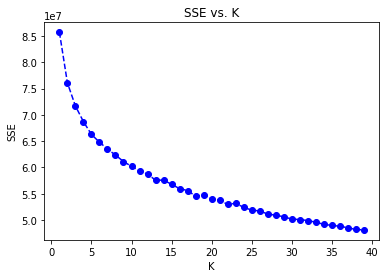

In [67]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [68]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# instantiate kmeans
kmeans_25 = KMeans(n_clusters=25)
# Then fit the model to your data using the fit method
model = kmeans_25.fit(gen_pop_pca40)
gen_pop_clusters=model.predict(gen_pop_pca40)

Clustering data with KMeans for a number of clusters higher than (roughly) 25 brings a comparatively small additional benefit to the clustering resolution, as measured through the SSE metric. 
Therefore, we have decided to stop our process having clustered data into 25 separate groups.

### Applying All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. 

In [83]:
# Load in the customer demographics data.
customers=pd.read_csv('customers.csv')
customers.drop(columns=['Unnamed: 0'],inplace=True)

In [86]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the customer demographics data.
encoded_customers=clean_data(customers)

191652


In [87]:
# There's something to notice and investigate here: the number of columns in the 
# ultimately encoded dataframes is NOT the same, so I have to figure out by which columns they differ 
gen_pop_encoded.shape[1], encoded_customers.shape[1]

(196, 195)

In [88]:
# If we look at the numers of columns and isolate the different one...
list1=list(gen_pop_encoded.columns)
list2=list(encoded_customers.columns)
list3=[i for i in list1 if i not in list2]
# we see that it is GEBAEUDETYP_5.0, an encoding result:
# this means that there ws not 5.0 entry in the values of GEBAEUDETYP 
# in the customers dataframe to begin with
list3

['build_5.0']

In [89]:
# So here comes a small hack: since we realised a posteriori that 
# clean_data() was giving a final result with less columns than gen_pop_encoded
# when applied to the customers dataset, we add the missing columns "by hand"

encoded_customers['GEBAEUDETYP_5.0']=0
# and now the columns should exactly match
gen_pop_encoded.shape[1], encoded_customers.shape[1]

(196, 196)

In [90]:
# We also reindex the columns of the encoded custmers dataframe to get perfect matching 
encoded_customers=encoded_customers.reindex(columns=list(gen_pop_encoded.columns))

In [91]:
# First we take a glance at the amount of missing values in the rows and the columns
encoded_customers.isna().sum(axis=1).value_counts(),encoded_customers.isna().sum(axis=0).value_counts();

In [92]:
# Imputing missing values...
imputed_customers=imp_most.transform(encoded_customers)

In [93]:
# ...then scaling the resulting dataframe... 
scaled_customers=std_scal.transform(imputed_customers) 

In [94]:
# ...then applying PCA to the customers data...
customers_pca40 = pca40.transform(scaled_customers)

In [95]:
# ...and, finally, Clustering pca-transformed customers data
customers_clusters=model.predict(customers_pca40)

### Comparing Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for the mail-order sales company maps onto those demographic clusters. Now we will compare the two cluster distributions to see where the strongest customer base for the company is, by considering the proportion of persons in each cluster for the general population, and the proportions for the customers. 

If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [96]:
# Here I check that the lengths of the clusters vectors match the numbers of rows in the cleaned dataframes
print(len(gen_pop_clusters)-gen_pop_encoded.shape[0],len(customers_clusters)-encoded_customers.shape[0])

# I must add to these vectors the numbers of rows which were rejected in the first place,
# since I did notice that they had some properties which told them apart from the rest of the general population

# To ths aim, I can create a couple of lists which include as last entries all th instances of the deleted rows for both # data frames
gen_pop_clusters_list=list(gen_pop_clusters)+[25 for i in range(gen_pop.shape[0]-gen_pop_encoded.shape[0])];
customers_clusters_list=list(customers_clusters)+[25 for i in range(customers.shape[0]-encoded_customers.shape[0])];

0 0


In [97]:
# In order to create a barplot of the absolute numbers of instances of the various clusters in the dataset,
# it can be useful to create a couple of dataframes from the two cluster vectors identified above
# I cannot zip them together because of the different lengths
df_gen_pop_clusters=pd.DataFrame(gen_pop_clusters_list,columns=['gen_pop'])
df_customers_clusters=pd.DataFrame(customers_clusters_list,columns=['customers'])

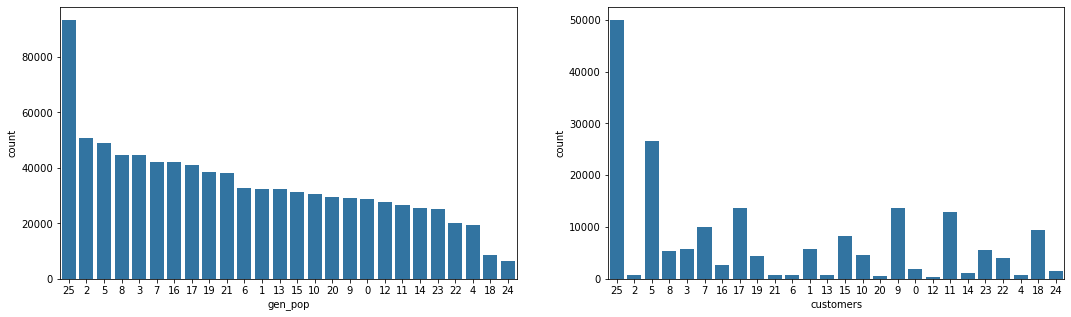

In [98]:
# Plotting the absolute numbers of instances of the various clusters,
# ordering the bars in such a way as to notice pattern changes between general population and customer base

plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
order_gen_pop=df_gen_pop_clusters['gen_pop'].value_counts().index
sns.countplot(x='gen_pop',data=df_gen_pop_clusters,color=sns.color_palette()[0],order=order_gen_pop);

plt.subplot(1,2,2)
order_customers=df_customers_clusters['customers'].value_counts().index
sns.countplot(x='customers',data=df_customers_clusters,color=sns.color_palette()[0],order=order_gen_pop);

plt.subplots_adjust(wspace=0.2)
plt.show()

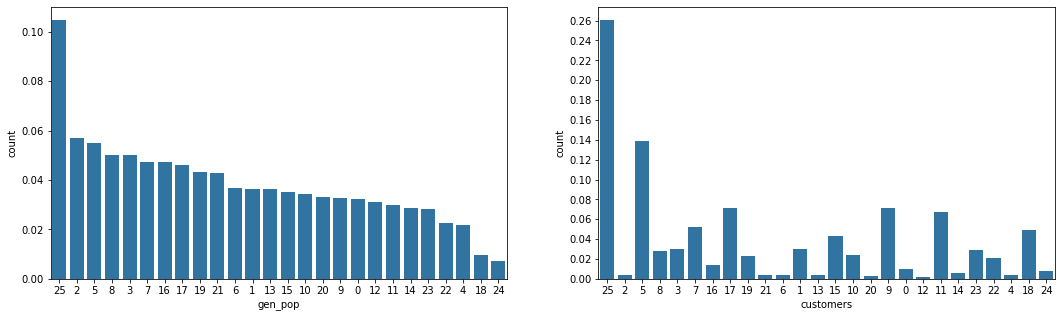

In [99]:
# Plotting the relative numbers of instances of the various clusters by modifying the y axis
# in the mage above  
plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
max_cluster_gen_pop=df_gen_pop_clusters['gen_pop'].value_counts().values[0]
max_prop_gen_pop=max_cluster_gen_pop/gen_pop.shape[0]
# Now let us define a spacing for the proportion plot, say 0.2, by which the extension of the plot gets up to 18%
tick_spaces_gen_pop=np.arange(0,max_prop_gen_pop,0.02)
# Let us create a string of values that will be used as tick labels
tick_names_gen_pop = ['{:0.2f}'.format(v) for v in tick_spaces_gen_pop]
# Make the final plot
sns.countplot(x='gen_pop',data=df_gen_pop_clusters,color=sns.color_palette()[0],order=order_gen_pop);
plt.yticks(tick_spaces_gen_pop * gen_pop.shape[0],tick_names_gen_pop);


plt.subplot(1,2,2)
max_cluster_customers=df_customers_clusters['customers'].value_counts().values[0]
max_prop_customers=max_cluster_customers/customers.shape[0]
# Now let us define a spacing for the proportion plot, say 0.2, by which the extension of the plot gets up to 18%
tick_spaces_customers=np.arange(0,max_prop_customers,0.02)
# Let us create a string of values that will be used as tick labels
tick_names_customers = ['{:0.2f}'.format(v) for v in tick_spaces_customers]
# Make the final plot
sns.countplot(x='customers',data=df_customers_clusters,color=sns.color_palette()[0],order=order_gen_pop);
plt.yticks(tick_spaces_customers * customers.shape[0],tick_names_customers);

plt.subplots_adjust(wspace=0.2)
plt.show()

In [100]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# First we compute such proportions for the general population dataset
gen_pop_clusters_count=[gen_pop_clusters_list.count(i) for i in range(25)]
gen_pop_clusters_prop=[x/gen_pop.shape[0] for x in gen_pop_clusters_count]
# Next we compute such proportions for the customers dataset
customers_clusters_count=[customers_clusters_list.count(i) for i in range(25)]
customers_clusters_prop=[x/customers.shape[0] for x in customers_clusters_count]
# This is simply a cluster identifier to incorporate into the dataframe in order to use the .barplot() method
cluster_id=list(range(25))
# Here comes the dataframe containing the proportions of data in each cluster
df_cluster_prop=pd.DataFrame(list(zip(cluster_id,gen_pop_clusters_count,customers_clusters_count,gen_pop_clusters_prop,customers_clusters_prop)),columns=['cluster_id','gen_pop_count','custom_count','gen_pop_prop','custom_prop'])

df_cluster_prop['prop_ratio']=df_cluster_prop['custom_prop']/df_cluster_prop['gen_pop_prop']

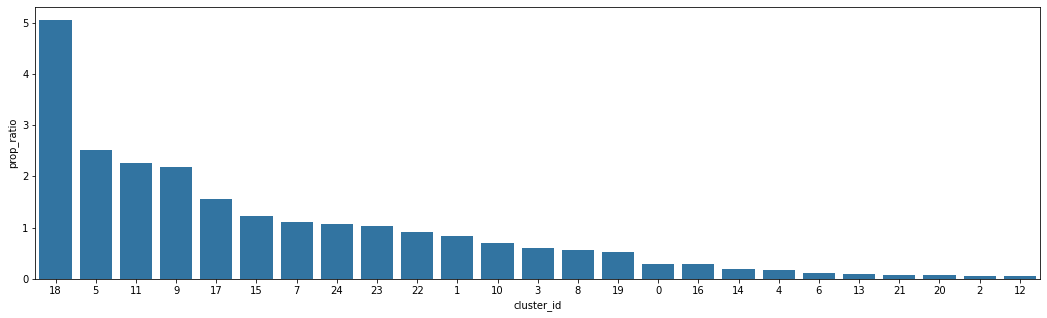

In [101]:
# Finally plotting the ratios of proportions of instances for the 25 identified clusters,
# odering them in such a way that the ones most overrepresented in the customer dataset are plotted first 
plt.figure(figsize=[18,5])
order_ratios=df_cluster_prop['prop_ratio'].sort_values(ascending=False).index
sns.barplot(x='cluster_id',y='prop_ratio',data=df_cluster_prop,color=sns.color_palette()[0],order=order_ratios);

It is clear from the plot below that the three leftmost clusters (and partially the fourth one) are heavily
overrepresented in the customer dataset, as compared to the general population.

Therefore, advertising campaigns should maximize their chance of success by targeting these kinds of people,
whose profile we are going to disentangle from data in the lines of code below.

It is otherwise clear that people in clusters number 23 and the following ones are really underrepresented,
so that the company could use this information to understand what kinds of people are not likely to purchase
goods from the company and, therefre, should are not worth the spending of the company's resources. 

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population ?
cluster_customers_ok=[pos for pos in range(len(customers_clusters)) if customers_clusters[pos]==order_ratios[0]]

# Now we can look at the pca components of any customer who is a member of cluster 19 and,
# knowing that the first three components we analysed above are the most impactful in terms of 
# explained variance, infer what kind of person belongs to this group: we'll do this with a couple of people 

In [103]:
# We can turn this 40-component vector back into a full-fledged 196-components vector
# by multiplying each of its components by the corresponding pca vector and then create a simple database
# to pair each value with its corresponding category; even better, we can take the average reconstructed vector
# Of course, due to lack of complete information (40 out of the original 196 components), 
# we are going to get something slightly weir-looing, like some slightly negative value and the like
# These results must be taken with a grain of salt, by focusing our attention on the most likely value for each category
# and remembering that negative values are only a by-product of the approximation we have made above 
df_cluster_customers_ok_avg=pd.DataFrame(list(zip(gen_pop_encoded.columns,std_scal.inverse_transform(np.average(np.dot(customers_pca40[cluster_customers_ok],pca40.components_),axis=0)))),columns=['features','average_components_ok'])

In [104]:
# We can easiy visualize the whole dataframe by selecting an appropirate Pandas option for the maximum nuµber 
# of displayed rows, in order to more easily understand the relevant attributes 
pd.set_option('display.max_rows',None)

In [105]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_customers_ko=[pos for pos in range(len(customers_clusters)) if customers_clusters[pos]==order_ratios[24]]
# Just as we did above
df_cluster_customers_ko_avg=pd.DataFrame(list(zip(gen_pop_encoded.columns,std_scal.inverse_transform(np.average(np.dot(customers_pca40[cluster_customers_ko],pca40.components_),axis=0)))),columns=['features','average_components_ko'])

We can actually join these two databases to make the comparison much easier

In [106]:
df_clusters_compare=df_cluster_customers_ok_avg
df_clusters_compare['average_components_ko']=df_cluster_customers_ko_avg['average_components_ko']

In [107]:
df_clusters_compare

,features,average_components_ok,average_components_ko
0,age_name,3.440024,2.055407
1,gender,1.222992,1.947890
2,fin_min,4.363652,1.367759
3,fin_saver,1.231773,4.179639
4,fin_beprep,4.748809,2.331941
5,fin_inv,1.321012,4.053625
6,fin_incos,1.832759,3.440915
7,fin_home_own,2.992327,4.188502
8,green_avan,0.701292,0.036365
9,health,1.852500,2.211456


Distinguishing different segments of the population within the customer datasets and identifying those segments on which the company's advertising efforts would certainly prove most profitable is definitely possible, as we have seen with the creation of the dataframes for the average values of the features for the most overrepresented and underrepresented clusters among customers compared to the general population.

From the first column of the df_clusters_compare dataframe, we can infer the kind of customer belonging to this cluster: mainly German male in between his 40s and 70s, he doesn't usually own neither a house nor a conspicous capital, receives a slightly above average income and is highly interested in saving his money through good commercial and even in investing it into maybe low return but consistent investments, especially if he is in the more affluent side of the spectrum. A rational and disciplined mind, perhaps sprinkled with a combatinve attitude are his core personality traits in the record, which make a pair with his belonging to the conservative layer of the upper middle class in regions with high to very high purchasing power, average levels of unemployment and in a community with more a number of people in between 100.000 and 1 million. He is single roughly twice as many times as he is married and. It is striking to notice how the feature CAMEO_DEU_2015_5D, qualifying "stock market junkies", stands out as relevant for lots of these people: it is of course coherent with the information coming from previously analyzed variables.


On the other hand, from the second column of the dataframe we can pin down the features of another kind of person, at the very opposite of the spectrum, who is very unlikely to shop from the company: this person is very often a much younger woman with an extremely low financial interest, a dreamful personality and -often- a marked social orientation. She earns much less than her male first-cluster counterpart but that's undertandable on the ground that she is at a stage of her life where she is seeking her own path, being by far more interested in (multi) culture than in the stock market.

In [1]:
!!jupyter nbconvert Identify_Customer_Segments.ipynb --to html

['[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.',
 '[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 3206617 bytes to Identify_Customer_Segments.html']